In [1]:
import pandas as pd
import numpy as np
from PIL import Image
from os import listdir
from os.path import isfile, join
import tensorflow as tf
import cv2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Model
from tensorflow.keras.layers import Input,Activation,Add, MaxPooling2D, Flatten, Dense
import gc

In [2]:
#Import image labels and paths to dataframe
mypath = "./Data/CroppedImages/"
filenames = np.array([f for f in listdir(mypath) if isfile(join(mypath, f))])
splitcolumns = [x.split('_')[0:3] + [mypath + x] for x in filenames if x.count('_') == 3]
filecolumns = ['age','gender','race','file']
filedf = pd.DataFrame(data = splitcolumns, columns = filecolumns)

In [3]:
# Stratified Sampling of gender 0
genderzerodf = filedf[filedf['gender'] == '0']
genderonedf = filedf[filedf['gender'] == '1']
traingender = genderzerodf.groupby('age', group_keys=False).apply(lambda x: x.sample(frac = 0.2))

In [4]:
# Get '0' test examples
testzero = genderzerodf.groupby('age', group_keys=False).apply(lambda x: x.sample(frac = 0.5))
# Get '1' test examples
testone = genderonedf.groupby('age', group_keys=False).apply(lambda x: x.sample(frac = 0.5))

In [5]:
def get_image_average(links):
    img_container = []
    for i in links:
        img = cv2.imread(i)
        img_container.append(img)
    return np.mean(img_container,axis = 0)

def get_descriptors(links):
    container = []
    sift = cv2.SIFT_create()
    for i in links:
        img = cv2.imread(i)
        img_bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        keypoint,descriptor = sift.detectAndCompute(img_bw,None)
        container.append([keypoint,descriptor])
    return container

def get_similarity(train,queries):
    matcher = cv2.BFMatcher()
    similarity = []
    for j in train:
        container = []
        for i in queries:
            if(any(elem is None for elem in [i[0],i[1],j[0],j[1]])):
                container.append(0)
                continue
            matches = matcher.knnMatch(i[1],j[1], k=2)
            number_keypoints = 0
            if len(j[0]) <= len(i[0]):
                number_keypoints = len(j[0])
            else:
                number_keypoints = len(i[0])
            # Apply ratio test
            good = []
            for m,n in matches:
                if m.distance < 0.75*n.distance:
                    good.append([m])        
            
            percent=(len(good)*100)/number_keypoints
            container.append(percent)
        similarity.append(container)
    return similarity

In [50]:
train = get_descriptors(traingender.loc[:,'file'])
test0 = get_descriptors(testzero.loc[:,'file'])
test1 = get_descriptors(testone.loc[:,'file'])

In [29]:
similarityzero = get_similarity(train,test0[:100])
similarityone = get_similarity(train,test1[:100])

In [32]:
np.mean(similarityzero)

3.1225699954555823

In [94]:
np.mean(similarityone)

1.2453637355712786

In [8]:
gender_zero_img = get_image_average(genderzerodf.loc[:,'file'])

In [47]:
from PIL import Image
im = Image.fromarray(gender_zero_img.astype(np.uint8))
im.save("test_zero_img.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


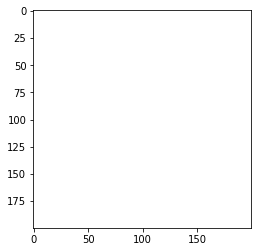

In [9]:
plt.imshow(gender_zero_img,cmap = 'gray')

In [13]:
gender_one_img = get_image_average(genderonedf.loc[:,'file'])

In [ ]:
plt.imshow(gender_one_img, cmap = 'gray')

In [48]:
sift = cv2.SIFT_create()
img = cv2.imread('test_zero_img.png')
img_bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
keypoint_mean,descriptor_mean = sift.detectAndCompute(img_bw,None)


In [52]:
similarity_zero_avg = get_similarity([[keypoint_mean,descriptor_mean]],test0)